# <center> Bài tập Thực hành môn Xử lý Đa chiều </center>

### **Họ và tên:** Huỳnh Nguyễn Thế Dân
### **MSSV:** 21110256
### **Lớp:** 21TTH1

# <center> Trả lời </center>

## Bài 2. Dữ liệu trong Research Articles chứa khoảng 30000 phần tóm tắt của các bài báo nghiên cứu.


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

# Đọc dữ liệu
train_data = pd.read_csv('dataset/train.csv/train.csv')
test_data = pd.read_csv('dataset/test.csv/test.csv')

def preprocess_text(text):
    tokens = [word for word in text.lower().split() if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
train_data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


Danh sách các chủ đề: Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance', 'tokens'],
      dtype='object')


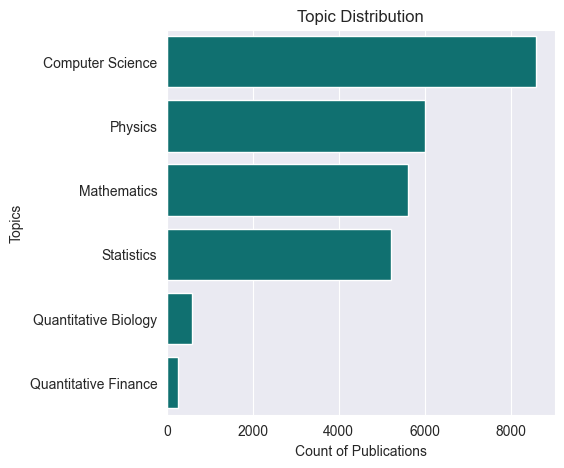

In [20]:
# a) Đọc dữ liệu và xem danh sách các chủ đề trong dữ liệu. Trực quan hóa số lượng bài đăng về mỗi chủ đề.
train_data['tokens'] = train_data['ABSTRACT'].apply(preprocess_text)
test_data['tokens'] = test_data['ABSTRACT'].apply(preprocess_text)

# Xem danh sách các chủ đề
topics = train_data.columns[3:]
print("Danh sách các chủ đề:", topics)

total_counts = train_data[['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']].sum(axis=0)
fig = plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
ax = sns.barplot(x=total_counts.values,y=total_counts.index,color='teal')
ax.set_title('Topic Distribution')
ax.set_xlabel('Count of Publications')
ax.set_ylabel('Topics')
plt.show()

In [21]:
# b) Tiền xử lý dữ liệu: ngắt từ, loại bỏ stopwords, tạo bigrams/trigrams.
bigram = Phrases(train_data['tokens'], min_count=5, threshold=100)
trigram = Phrases(bigram[train_data['tokens']], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

train_data['bigrams'] = train_data['tokens'].apply(lambda x: bigram_mod[x])
train_data['trigrams'] = train_data['bigrams'].apply(lambda x: trigram_mod[x])

test_data['bigrams'] = test_data['tokens'].apply(lambda x: bigram_mod[x])
test_data['trigrams'] = test_data['bigrams'].apply(lambda x: trigram_mod[x])


In [22]:
# c) Tạo dictionary và bag-of-word từ dữ liệu đã xử lý.
dictionary = Dictionary(train_data['trigrams'])
corpus = [dictionary.doc2bow(text) for text in train_data['trigrams']]
test_corpus = [dictionary.doc2bow(text) for text in test_data['trigrams']]

In [24]:
# d) Xây dựng mô hình LDA để xử lý bài toán topic modeling cho dữ liệu này với số chủ đề là 6. In ra các từ khóa cho mỗi chủ đề. Tính perplexity và điểm coherence.
num_topics = 6
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# In ra các từ khóa cho mỗi chủ đề
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Tính perplexity và điểm coherence
print('\nPerplexity: ', lda_model.log_perplexity(test_corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=train_data['trigrams'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(0, '0.012*"data" + 0.011*"model" + 0.009*"network" + 0.008*"method" + 0.007*"approach" + 0.006*"using" + 0.005*"propose" + 0.005*"show" + 0.005*"based" + 0.005*"new"')
(1, '0.014*"polynomial" + 0.013*"transformation" + 0.012*"definition" + 0.011*"characterize" + 0.011*"category" + 0.011*"content" + 0.010*"closed" + 0.009*"contains" + 0.009*"=" + 0.009*"assessment"')
(2, '0.010*"system" + 0.007*"state" + 0.006*"energy" + 0.005*"effect" + 0.005*"dynamic" + 0.005*"study" + 0.005*"model" + 0.005*"show" + 0.005*"interaction" + 0.005*"phase"')
(3, '0.014*"algorithm" + 0.014*"problem" + 0.012*"method" + 0.012*"model" + 0.008*"parameter" + 0.008*"distribution" + 0.008*"function" + 0.007*"time" + 0.007*"optimal" + 0.006*"linear"')
(4, '0.007*"mass" + 0.006*"spectrum" + 0.005*"density" + 0.005*"cluster" + 0.005*"observed" + 0.004*"motion" + 0.004*"find" + 0.004*"idea" + 0.004*"measurement" + 0.004*"observation"')
(5, '0.009*"result" + 0.009*"show" + 0.007*"space" + 0.007*"prove" + 0.007*"also" 

In [25]:
# e) Dùng pyLDAvis để trực quan hóa các chủ đề. Nhận xét.
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


In [26]:
# f) Bổ sung thêm bước lemmatization trong quá trình tiền xử lý dữ liệu. Xây dựng lại mô hình LDA và so sánh kết quả với mô hình khi không có lemmatization.
train_data['lemmatized'] = train_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
test_data['lemmatized'] = test_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Tạo bigrams/trigrams từ dữ liệu đã lemmatized
train_data['bigrams_lemmatized'] = train_data['lemmatized'].apply(lambda x: bigram_mod[x])
train_data['trigrams_lemmatized'] = train_data['bigrams_lemmatized'].apply(lambda x: trigram_mod[x])

test_data['bigrams_lemmatized'] = test_data['lemmatized'].apply(lambda x: bigram_mod[x])
test_data['trigrams_lemmatized'] = test_data['bigrams_lemmatized'].apply(lambda x: trigram_mod[x])

# Tạo dictionary và corpus từ dữ liệu đã lemmatized
dictionary_lemmatized = Dictionary(train_data['trigrams_lemmatized'])
corpus_lemmatized = [dictionary_lemmatized.doc2bow(text) for text in train_data['trigrams_lemmatized']]
test_corpus_lemmatized = [dictionary_lemmatized.doc2bow(text) for text in test_data['trigrams_lemmatized']]

# Xây dựng mô hình LDA từ dữ liệu đã lemmatized
lda_model_lemmatized = LdaModel(corpus=corpus_lemmatized, id2word=dictionary_lemmatized, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# In ra các từ khóa cho mỗi chủ đề từ mô hình lemmatized
topics_lemmatized = lda_model_lemmatized.print_topics(num_words=10)
for topic in topics_lemmatized:
    print(topic)

# Tính perplexity và điểm coherence cho mô hình lemmatized
print('\nPerplexity: ', lda_model_lemmatized.log_perplexity(test_corpus_lemmatized))
coherence_model_lda_lemmatized = CoherenceModel(model=lda_model_lemmatized, texts=train_data['trigrams_lemmatized'], dictionary=dictionary_lemmatized, coherence='c_v')
coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
print('\nCoherence Score: ', coherence_lda_lemmatized)

(0, '0.021*"method" + 0.015*"model" + 0.014*"algorithm" + 0.014*"network" + 0.010*"approach" + 0.010*"propose" + 0.010*"proposed" + 0.009*"learning" + 0.008*"data" + 0.007*"feature"')
(1, '0.015*"let" + 0.008*"affine" + 0.006*"$x$" + 0.006*"\\in" + 0.005*"$f$" + 0.005*"$" + 0.005*"(iii)" + 0.004*"$a$" + 0.004*"symbol" + 0.004*"$$"')
(2, '0.009*"problem" + 0.009*"show" + 0.009*"result" + 0.008*"function" + 0.007*"also" + 0.006*"number" + 0.006*"solution" + 0.005*"two" + 0.005*"set" + 0.005*"linear"')
(3, '0.011*"data" + 0.010*"model" + 0.007*"system" + 0.006*"using" + 0.005*"based" + 0.005*"present" + 0.004*"analysis" + 0.004*"time" + 0.004*"different" + 0.004*"used"')
(4, '0.006*"energy" + 0.005*"state" + 0.005*"phase" + 0.005*"model" + 0.004*"system" + 0.004*"quantum" + 0.004*"structure" + 0.004*"using" + 0.004*"effect" + 0.004*"temperature"')
(5, '0.014*"mass" + 0.010*"galaxy" + 0.008*"star" + 0.006*"stellar" + 0.005*"ion" + 0.005*"disk" + 0.005*"cosmological" + 0.005*"dark_matter" +

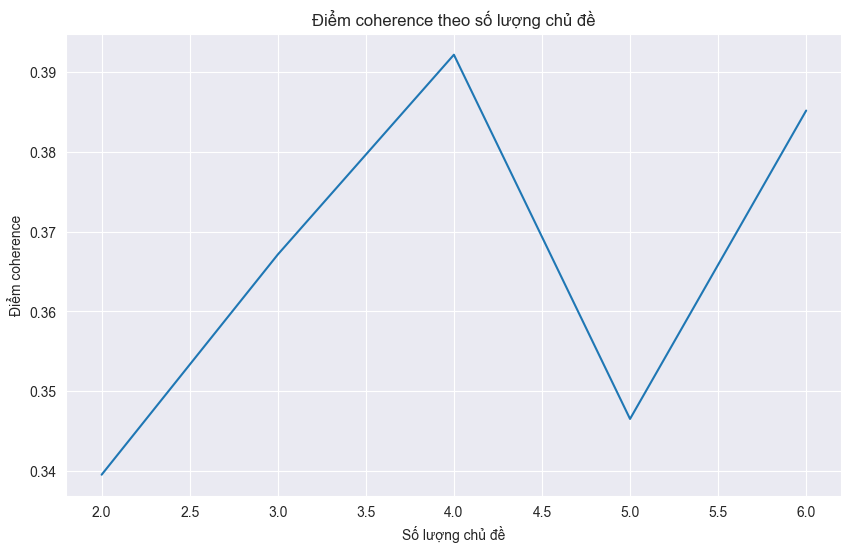

Số lượng chủ đề tốt nhất:  4


In [28]:
# g) Điều chỉnh số lượng chủ đề, xây dựng lại mô hình LDA và tính điểm coherence. Chọn số lượng chủ đề tốt nhất cho dữ liệu này.
coherence_values = []
model_list = []
num_topics_list = [2, 3, 4, 5, 6]

for num_topics in num_topics_list:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=train_data['trigrams'], dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

# Trực quan hóa điểm coherence theo số lượng chủ đề
plt.figure(figsize=(10,6))
plt.plot(num_topics_list, coherence_values)
plt.xlabel('Số lượng chủ đề')
plt.ylabel('Điểm coherence')
plt.title('Điểm coherence theo số lượng chủ đề')
plt.show()

# Chọn số lượng chủ đề tốt nhất
best_num_topics = num_topics_list[coherence_values.index(max(coherence_values))]
print('Số lượng chủ đề tốt nhất: ', best_num_topics)